In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [16]:
df = pd.read_csv('/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/tariff_war/raw_data/2025_jun30_tariffwar.csv')  # replace with your file path
# df.set_index("Year", inplace=True)
df = df.dropna()
df.columns

Index(['Unnamed: 0', 'Year', 'Hurs', 'pr', 'tas', 'exchange_rate',
       'Trade_value_brazil_china', 'soy_production(ton)',
       'Soybean_production(h)', 'Export_Usa_china_MT', 'forest_loss_PA (h)',
       'forest_loss_SC (h)', 'natural_forest_loss (h)',
       'non_natural_forest_loss (h)'],
      dtype='object')

In [17]:
df.columns

Index(['Unnamed: 0', 'Year', 'Hurs', 'pr', 'tas', 'exchange_rate',
       'Trade_value_brazil_china', 'soy_production(ton)',
       'Soybean_production(h)', 'Export_Usa_china_MT', 'forest_loss_PA (h)',
       'forest_loss_SC (h)', 'natural_forest_loss (h)',
       'non_natural_forest_loss (h)'],
      dtype='object')

In [18]:
# time series
y = df['natural_forest_loss (h)']

# exogenous variables
X = df[['Hurs', 'pr', 'tas', 'soy_production(ton)',
       'Soybean_production(h)']]  # can include more variables if you have them

In [19]:
result = adfuller(y)
print(f"ADF statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

# if p > 0.05 → non-stationary, you may consider differencing:
if result[1] > 0.05:
    y_diff = y.diff().dropna()
    adf2 = adfuller(y_diff)
    print(f"Differenced ADF statistic: {adf2[0]:.3f}, p-value: {adf2[1]:.3f}")
else:
    y_diff = y  # already stationary

ADF statistic: -2.691
p-value: 0.076
Differenced ADF statistic: -1.775, p-value: 0.393


In [20]:
y_diff2 = y.diff().diff().dropna()
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(y_diff2)
print(f"2nd diff ADF statistic: {adf_result[0]}, p-value: {adf_result[1]}")

2nd diff ADF statistic: -2.908488598315743, p-value: 0.044369756169067964


✅ SARIMAX Evaluation (2013–2015):
RMSE: 443977.49
R²: -13.7484

📊 A/B Impact Analysis (2016–2024):
   Year  Actual_Forest_Loss  Predicted_Counterfactual    Difference  \
0  2016        3.214767e+06              4.921254e+05  2.722642e+06   
1  2017        2.498636e+06              1.053012e+06  1.445624e+06   
2  2018        1.566973e+06              4.120046e+05  1.154969e+06   
3  2019        1.512562e+06              6.518497e+05  8.607120e+05   
4  2020        2.412874e+06              1.220024e+05  2.290872e+06   
5  2021        2.937789e+06              3.303880e+05  2.607401e+06   
6  2022        3.430619e+06              1.809647e+04  3.412523e+06   
7  2023        3.070628e+06              8.872940e+05  2.183334e+06   

       %_Change  
0    553.241370  
1    137.284650  
2    280.329107  
3    132.041467  
4   1877.726952  
5    789.193486  
6  18857.390543  
7    246.066592  


/Users/mustakahmad/Library/CloudStorage/OneDrive-purdue.edu/FACAI LAB/Project3_tariff/proj3env/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


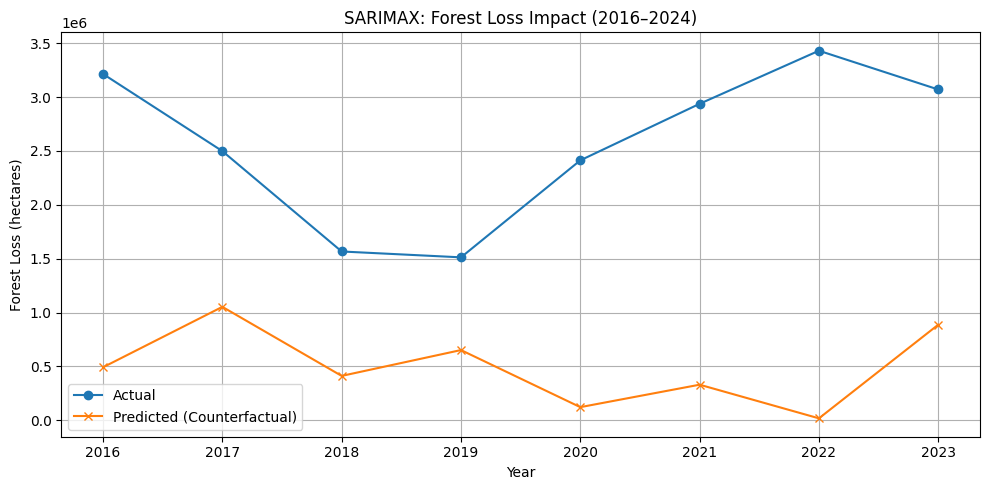

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------
# Step 1: Prepare the data
# -------------------------------

# Sort by year
df = df.sort_values("Year").reset_index(drop=True)

# Apply log transformation to the target
df['log_forest_loss'] = np.log1p(df['natural_forest_loss (h)'])

# Define exogenous variables
exog_vars = ['Hurs', 'pr', 'tas', 'soy_production(ton)', 'Soybean_production(h)']

# Drop NA if any
df = df.dropna(subset=exog_vars + ['log_forest_loss']).reset_index(drop=True)

# -------------------------------
# Step 2: Train-Test Split
# -------------------------------

train_mask = df['Year'] <= 2013
eval_mask = (df['Year'] >= 2014) & (df['Year'] <= 2015)
impact_mask = df['Year'] >= 2016

y_train = df.loc[train_mask, 'log_forest_loss']
X_train = df.loc[train_mask, exog_vars]

y_eval = df.loc[eval_mask, 'log_forest_loss']
X_eval = df.loc[eval_mask, exog_vars]

y_impact = df.loc[impact_mask, 'log_forest_loss']
X_impact = df.loc[impact_mask, exog_vars]
years_impact = df.loc[impact_mask, 'Year']

# -------------------------------
# Step 3: Fit SARIMAX Model
# -------------------------------

model = SARIMAX(endog=y_train,
                exog=X_train,
                order=(1, 1, 1),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# -------------------------------
# Step 4: Predict on Evaluation Set (2013–2015)
# -------------------------------

# Number of evaluation steps
n_eval = len(X_eval)

# Forecast with matching exog
y_pred_eval_log = results.forecast(steps=n_eval, exog=X_eval)
y_pred_eval = np.expm1(y_pred_eval_log)
y_eval_actual = np.expm1(y_eval)

# Metrics
rmse_eval = np.sqrt(mean_squared_error(y_eval_actual, y_pred_eval))
r2_eval = r2_score(y_eval_actual, y_pred_eval)

print("✅ SARIMAX Evaluation (2013–2015):")
print(f"RMSE: {rmse_eval:.2f}")
print(f"R²: {r2_eval:.4f}")

# -------------------------------
# Step 5: Forecast 2016–2024
# -------------------------------

n_impact = len(X_impact)
y_pred_impact_log = results.forecast(steps=n_impact, exog=X_impact)
y_pred_impact = np.expm1(y_pred_impact_log)
y_impact_actual = np.expm1(y_impact)

# Combine for impact analysis
impact_df = pd.DataFrame({
    'Year': years_impact.values,
    'Actual_Forest_Loss': y_impact_actual.values,
    'Predicted_Counterfactual': y_pred_impact.values
})
impact_df['Difference'] = impact_df['Actual_Forest_Loss'] - impact_df['Predicted_Counterfactual']
impact_df['%_Change'] = (impact_df['Difference'] / impact_df['Predicted_Counterfactual']) * 100

print("\n📊 A/B Impact Analysis (2016–2024):")
print(impact_df)

# -------------------------------
# Step 6: Visualize Impact
# -------------------------------

plt.figure(figsize=(10, 5))
plt.plot(impact_df['Year'], impact_df['Actual_Forest_Loss'], label='Actual', marker='o')
plt.plot(impact_df['Year'], impact_df['Predicted_Counterfactual'], label='Predicted (Counterfactual)', marker='x')
plt.title("SARIMAX: Forest Loss Impact (2016–2024)")
plt.xlabel("Year")
plt.ylabel("Forest Loss (hectares)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()